<a href="https://colab.research.google.com/github/chikisam999/GazouKougaku/blob/main/Dogs_vs_Cats_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
import tensorflow
from tensorflow import keras

In [261]:
%matplotlib inline

In [262]:
import matplotlib.pyplot as plt

In [263]:
import os, cv2, random
import numpy as np
import pandas as pd

In [264]:
from matplotlib import ticker

In [265]:
import seaborn as sns

トレーニングデータの準備

In [266]:
TRAIN_DIR = "./train/"
TEST_DIR = "./test/"

In [267]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [268]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

In [269]:
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]

In [270]:
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

In [271]:
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

リストのスライス処理

In [272]:
train_images = train_dogs[:1000] + train_cats[:1000]

In [273]:
random.shuffle(train_images)

In [274]:
test_images = test_images[:25]

画像ファイルを多次元配列に変換する

In [275]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [276]:
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T #transpose mxn > nxm
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
            
    return data

In [277]:
train = prep_data(train_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000


In [278]:
test = prep_data(test_images)

Processed 0 of 25


In [279]:
train.shape, test.shape

((2000, 3, 64, 64), (25, 3, 64, 64))

ラベル一覧をリスト型整数に格納しよう

In [280]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'cat and dogs')

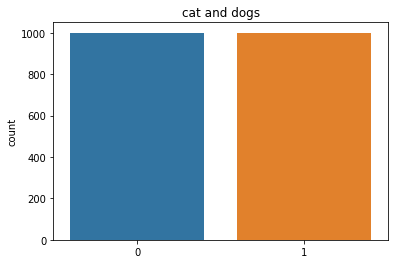

In [281]:
sns.countplot(labels)
plt.title('cat and dogs')

In [282]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis = 1)
    plt.figure(figsize = (10,5))
    plt.imshow(pair)
    plt.show()

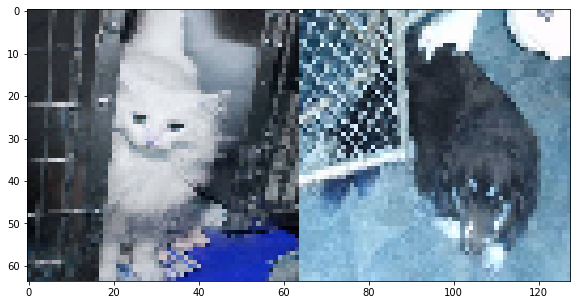

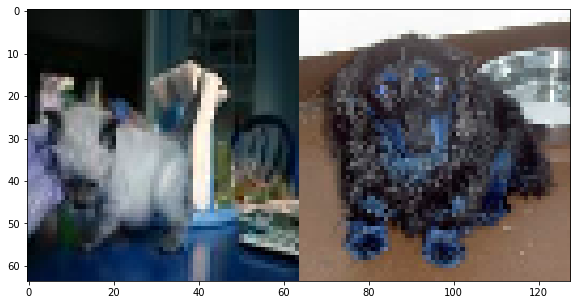

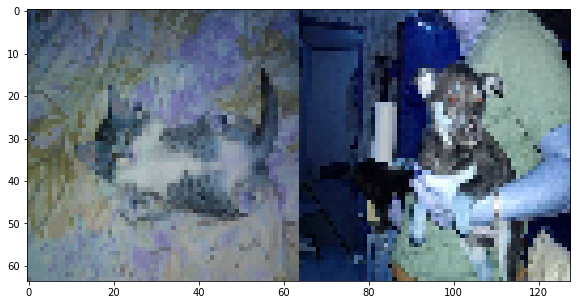

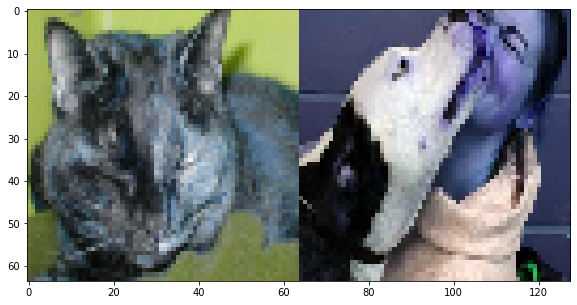

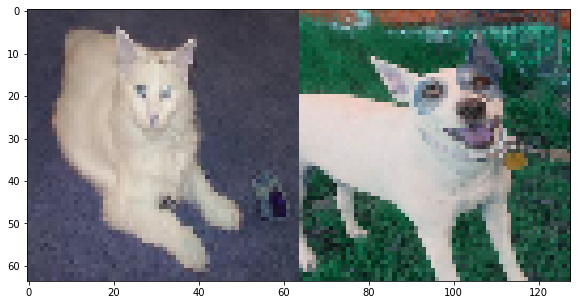

In [283]:
for idx in range(0,5):
    show_cats_and_dogs(idx)

ピクセル画像の平均を生成する

In [284]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)

Text(0.5, 1.0, 'Your Average Dog')

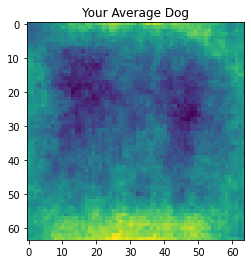

In [285]:
plt.imshow(dog_avg)
plt.title('Your Average Dog')

Text(0.5, 1.0, 'Your average cat')

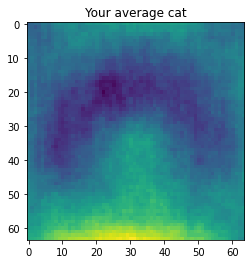

In [286]:
cat_avg = np.array([cat[0].T for i,cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your average cat')

CatDogNet-16を定義する。

In [287]:
labels = np.array(labels)

In [288]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
#np_utils maybe not used so comented out
#from tensorflow.keras.utils import np_utils

In [289]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [290]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()
#タプルで受け取る。

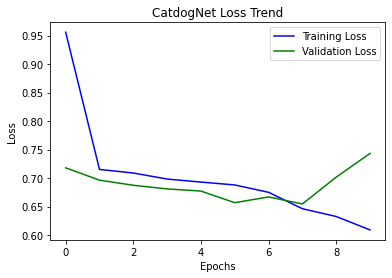

In [291]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('CatdogNet Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

I am 55.03% sure this is a Cat


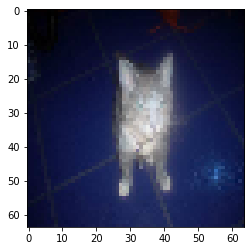

I am 58.90% sure this is a Dog


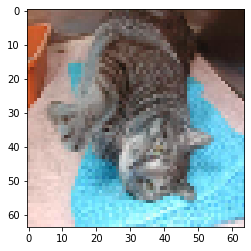

I am 61.52% sure this is a Cat


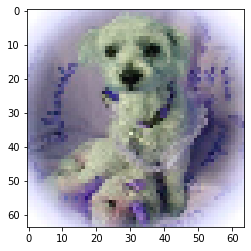

I am 68.15% sure this is a Dog


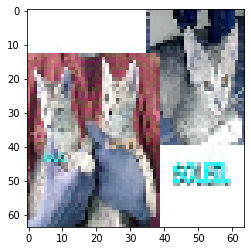

I am 52.82% sure this is a Dog


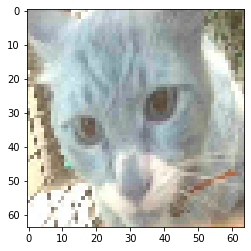

I am 77.21% sure this is a Cat


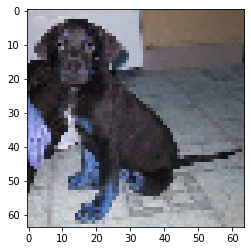

I am 67.68% sure this is a Cat


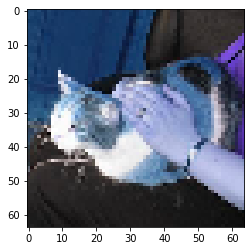

I am 73.73% sure this is a Dog


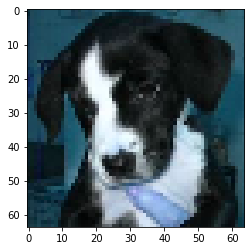

I am 84.26% sure this is a Dog


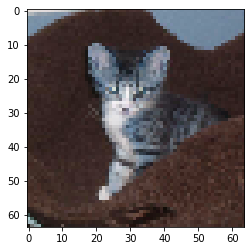

I am 55.05% sure this is a Cat


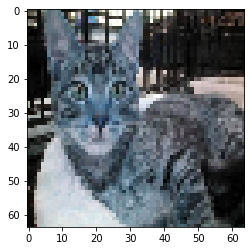

In [292]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()